In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [25]:
df = (sqlContext.read.load("/guoda/data/idigbio-20190612T171757.parquet")
    )

Calculate features

In [26]:
from pyspark.ml.linalg import Vectors, VectorUDT

#data = [(Vectors.dense([0.0, 0.0]),), (Vectors.dense([1.0, 1.0]),),
#       (Vectors.dense([9.0, 8.0]),), (Vectors.dense([8.0, 9.0]),)]
#print(spark.createDataFrame(data, ["features"]).head(10))

In [27]:
from pyspark.sql.functions import col, length, udf
import re

hex_chars = re.compile(r'[0-9a-fA-F]')
special_chars = re.compile(r'[\:\\\-_ ]')

def make_features(occurrenceid):
    return Vectors.dense(
        len(occurrenceid),
        len(re.findall(hex_chars, occurrenceid)),
        len(re.findall(special_chars, occurrenceid))
    )
    #return [float(len(occurrenceid)), 5.0]

make_features_udf = udf(make_features, VectorUDT())
    
# length(col("occurrenceid")
features = (df
            .select(col("occurrenceid"),
                make_features_udf(col("occurrenceid")).alias("features"))
            .persist()
            )

#features = df.rdd.map(lambda x: Vectors.dense(len(x["occurrenceid"])))

In [28]:
features.head(10)

[Row(occurrenceid='urn:uuid:9372ac72-aeab-11e3-8259-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0])),
 Row(occurrenceid='urn:uuid:854d29a6-d8e1-11e2-99a2-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0])),
 Row(occurrenceid='urn:uuid:8380600c-d8e1-11e2-99a2-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0])),
 Row(occurrenceid='urn:uuid:8477e052-d8e1-11e2-99a2-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0])),
 Row(occurrenceid='urn:uuid:8423b018-d8e1-11e2-99a2-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0])),
 Row(occurrenceid='urn:uuid:868baa7c-d8e1-11e2-99a2-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0])),
 Row(occurrenceid='urn:uuid:85a4303e-d8e1-11e2-99a2-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0])),
 Row(occurrenceid='urn:uuid:88037dd0-d8e1-11e2-99a2-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0])),
 Row(occurrenceid='urn:uuid:846d0bdc-d8e1-11e2-99a2-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0])),
 Row(occurrenceid='

In [29]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=4, seed=1)
model = kmeans.fit(features)

In [30]:
centers = model.clusterCenters()
print(centers)

[array([ 36.94971975,  32.00587473,   4.21890485]), array([ 60.77813604,  26.27229552,   3.02054589]), array([ 12.7707872 ,   7.79042064,   1.39948822]), array([ 28.68818093,  11.90653144,   4.04075096])]


In [31]:
import pandas as pd
centers_df = pd.DataFrame(centers)
centers_df

,0,1,2
0,36.949720,32.005875,4.218905
1,60.778136,26.272296,3.020546
2,12.770787,7.790421,1.399488
3,28.688181,11.906531,4.040751


In [32]:
# graph centers

In [33]:
# what are the most important axes? pca

In [34]:
# select those dimensions from graph centers and plot in 2 dimensions

That's cool, how do we know 4 is a good k?

In [35]:
# parallel arrays for the win
ks = []
models = []
centers = []
costs = []

for i in range(5, 21):
    kmeans = KMeans(k=i, seed=1)
    model = kmeans.fit(features)
    ks.append(i)
    models.append(model)
    centers.append(model.clusterCenters())
    costs.append(model.computeCost(features))



In [36]:
# predict as a UDF to run on all data to find examples of things in the clusters

In [37]:
#print(models)
print(costs)

[5517516631.12075, 2717303410.0655875, 1833910073.2626684, 1551452657.0152106, 1339107975.7685483, 1046085711.3787776, 1102391410.4102342, 807424472.9293461, 591909130.3742176, 518034490.4488958, 451134474.92578864, 411460514.6268028, 365942039.9499283, 420079481.6905408, 343392345.5673457, 322801372.64355814]


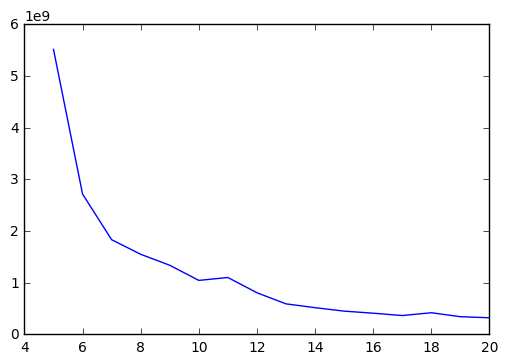

In [38]:
plt.plot(ks, costs)

In [39]:
final_k = 15

In [40]:
centers_df = pd.DataFrame(centers[ks.index(final_k)])
centers_df

,0,1,2
0,36.001007,32.000000,4.000000
1,63.001644,41.000653,6.000219
2,24.868540,9.992323,3.866530
3,30.219772,10.968493,4.135722
4,87.950355,44.184145,6.437326
5,51.085162,16.813212,1.299206
6,67.419288,23.032467,2.056481
7,43.406230,16.408471,6.556142
8,60.892954,22.374162,2.188133
9,80.678496,25.824196,1.365853


Need to count number of records for each cluster

In [41]:
final_model = models[ks.index(final_k)]

#.predict([51, 17, 1.1])

final_model.summary.predictions.head(10)

[Row(occurrenceid='urn:uuid:9372ac72-aeab-11e3-8259-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0]), prediction=13),
 Row(occurrenceid='urn:uuid:854d29a6-d8e1-11e2-99a2-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0]), prediction=13),
 Row(occurrenceid='urn:uuid:8380600c-d8e1-11e2-99a2-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0]), prediction=13),
 Row(occurrenceid='urn:uuid:8477e052-d8e1-11e2-99a2-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0]), prediction=13),
 Row(occurrenceid='urn:uuid:8423b018-d8e1-11e2-99a2-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0]), prediction=13),
 Row(occurrenceid='urn:uuid:868baa7c-d8e1-11e2-99a2-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0]), prediction=13),
 Row(occurrenceid='urn:uuid:85a4303e-d8e1-11e2-99a2-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0]), prediction=13),
 Row(occurrenceid='urn:uuid:88037dd0-d8e1-11e2-99a2-0026552be7ea', features=DenseVector([45.0, 33.0, 6.0]), prediction=13),
 Row(occ

In [42]:
sizes = (final_model.summary.predictions
         .groupBy(col("prediction"))
         .count()
         .orderBy(col("prediction"))
         .toPandas()
         )

max_size = 1000
sizes["scaled"] = (sizes["count"] / sizes["count"].max() ) * max_size

In [43]:
sizes.head(10)

,prediction,count,scaled
0,0,34001812,1000.000000
1,1,6972256,205.055425
2,2,9066940,266.660494
3,3,8206210,241.346255
4,4,719122,21.149520
5,5,7541086,221.784827
6,6,4136471,121.654428
7,7,1444498,42.482971
8,8,8002105,235.343487
9,9,519506,15.278774


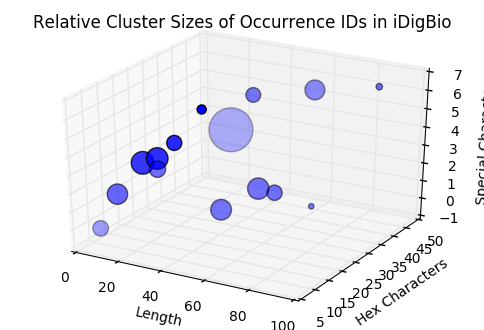

In [44]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=centers_df[0], ys=centers_df[1], zs=centers_df[2], s=sizes["scaled"])

plt.title("Relative Cluster Sizes of Occurrence IDs in iDigBio")
plt.xlabel("Length")
plt.ylabel("Hex Characters")
ax.set_zlabel("Special Characters")

lets take a look at a sampling of these clusters

In [46]:
for i in [0, 1, 2, 3]:
    print("Cluster {0}".format(i))
    print(final_model.summary.predictions
     .filter(col("prediction") == i)
     .select(col("occurrenceid"))
     .limit(5)
     .toPandas()
     )

Cluster 0
                           occurrenceid
0  ab4b824f-cb32-4870-85a1-cfba5863f181
1  c45321af-1b2d-4a6b-86db-10c0caf9e5a7
2  c2d06f51-8ffc-482a-b0fe-eb83886fad05
3  d13e61da-1c73-4c69-93d4-9a8853b26052
4  500dd1ae-b7f3-4256-9f5e-5f2b465c80b7
Cluster 1
                                        occurrenceid
0  http://n2t.net/ark:/65665/3260ff981-245b-4289-...
1  http://n2t.net/ark:/65665/32610ab90-905d-43ce-...
2  http://n2t.net/ark:/65665/32610b145-58a0-4015-...
3  http://n2t.net/ark:/65665/32610b21c-1f1b-408c-...
4  http://n2t.net/ark:/65665/32610e9e1-c9c3-4180-...
Cluster 2
                 occurrenceid
0  urn:catalog:cas:bot:476352
1   urn:catalog:cas:ds:371295
2  urn:catalog:cas:bot:573557
3  urn:catalog:cas:bot:759879
4  urn:catalog:cas:bot:900371
Cluster 3
                   occurrenceid
0  urn:catalog:zmbn:ent:c-18558
1  urn:catalog:zmbn:ent:c-18562
2  urn:catalog:zmbn:ent:c-18568
3  urn:catalog:zmbn:ent:c-18583
4  urn:catalog:zmbn:ent:c-18585
